In [1]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool2D, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D, LeakyReLU, Conv2D, AveragePooling2D, Dropout, Flatten, Lambda, Dense, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22#43#22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14#28#14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16#32#16
        self.data_dir = 'E:\Skelnet2D\data\SHREC\\'
C = Config()

In [5]:
# model
dropout_probability = 0.1
duration = 32
n_classes = 14
n_channels = 22  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints
filters = 16

In [6]:
def c2D(x,filters,kernel,init_mode='uniform'):
    x = Conv2D(filters, kernel_size=kernel,padding='same',use_bias=False,kernel_initializer=init_mode)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpatialDropout2D(dropout_probability)(x)
    return x

def block(x,filters,init_mode='uniform'):
    x = c2D(x,filters,3,init_mode)
    x = c2D(x,filters,3,init_mode)
    return x
    
def d2D(x,filters,init_mode='uniform'):
    x = Dense(filters,use_bias=False,kernel_initializer=init_mode)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [7]:
def create_model(n_classes=14, duration=32, n_channels=22, dropout_probability=0.2, optimizer = 'adam', init_mode='he_uniform'):
    model_input = Input(shape=(duration, n_channels,3))
    
    high = c2D(model_input, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    
    low = c2D(model_input, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    
    ap_residual = AveragePooling2D((2, 2), padding='same', input_shape=(32,n_channels, 1))(model_input)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    
    channel_output = concatenate([low,high,ap_residual])
    features = block(channel_output,filters*2)
    features = block(channel_output,filters*2)
    features = GlobalAveragePooling2D()(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    model_output = Dense(units=n_classes, activation='softmax')(features)
        
    model = Model(inputs=[model_input], outputs=[model_output])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [8]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 22, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 22, 32)   4704        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 22, 32)   128         conv2d_3[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 4, 3, 32)     9216        spatial_dropout2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 3, 32)     128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 4, 3, 32)     0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 4, 3, 32)     0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 32)           0           spatial_dropout2d_9[0][0]        
__________

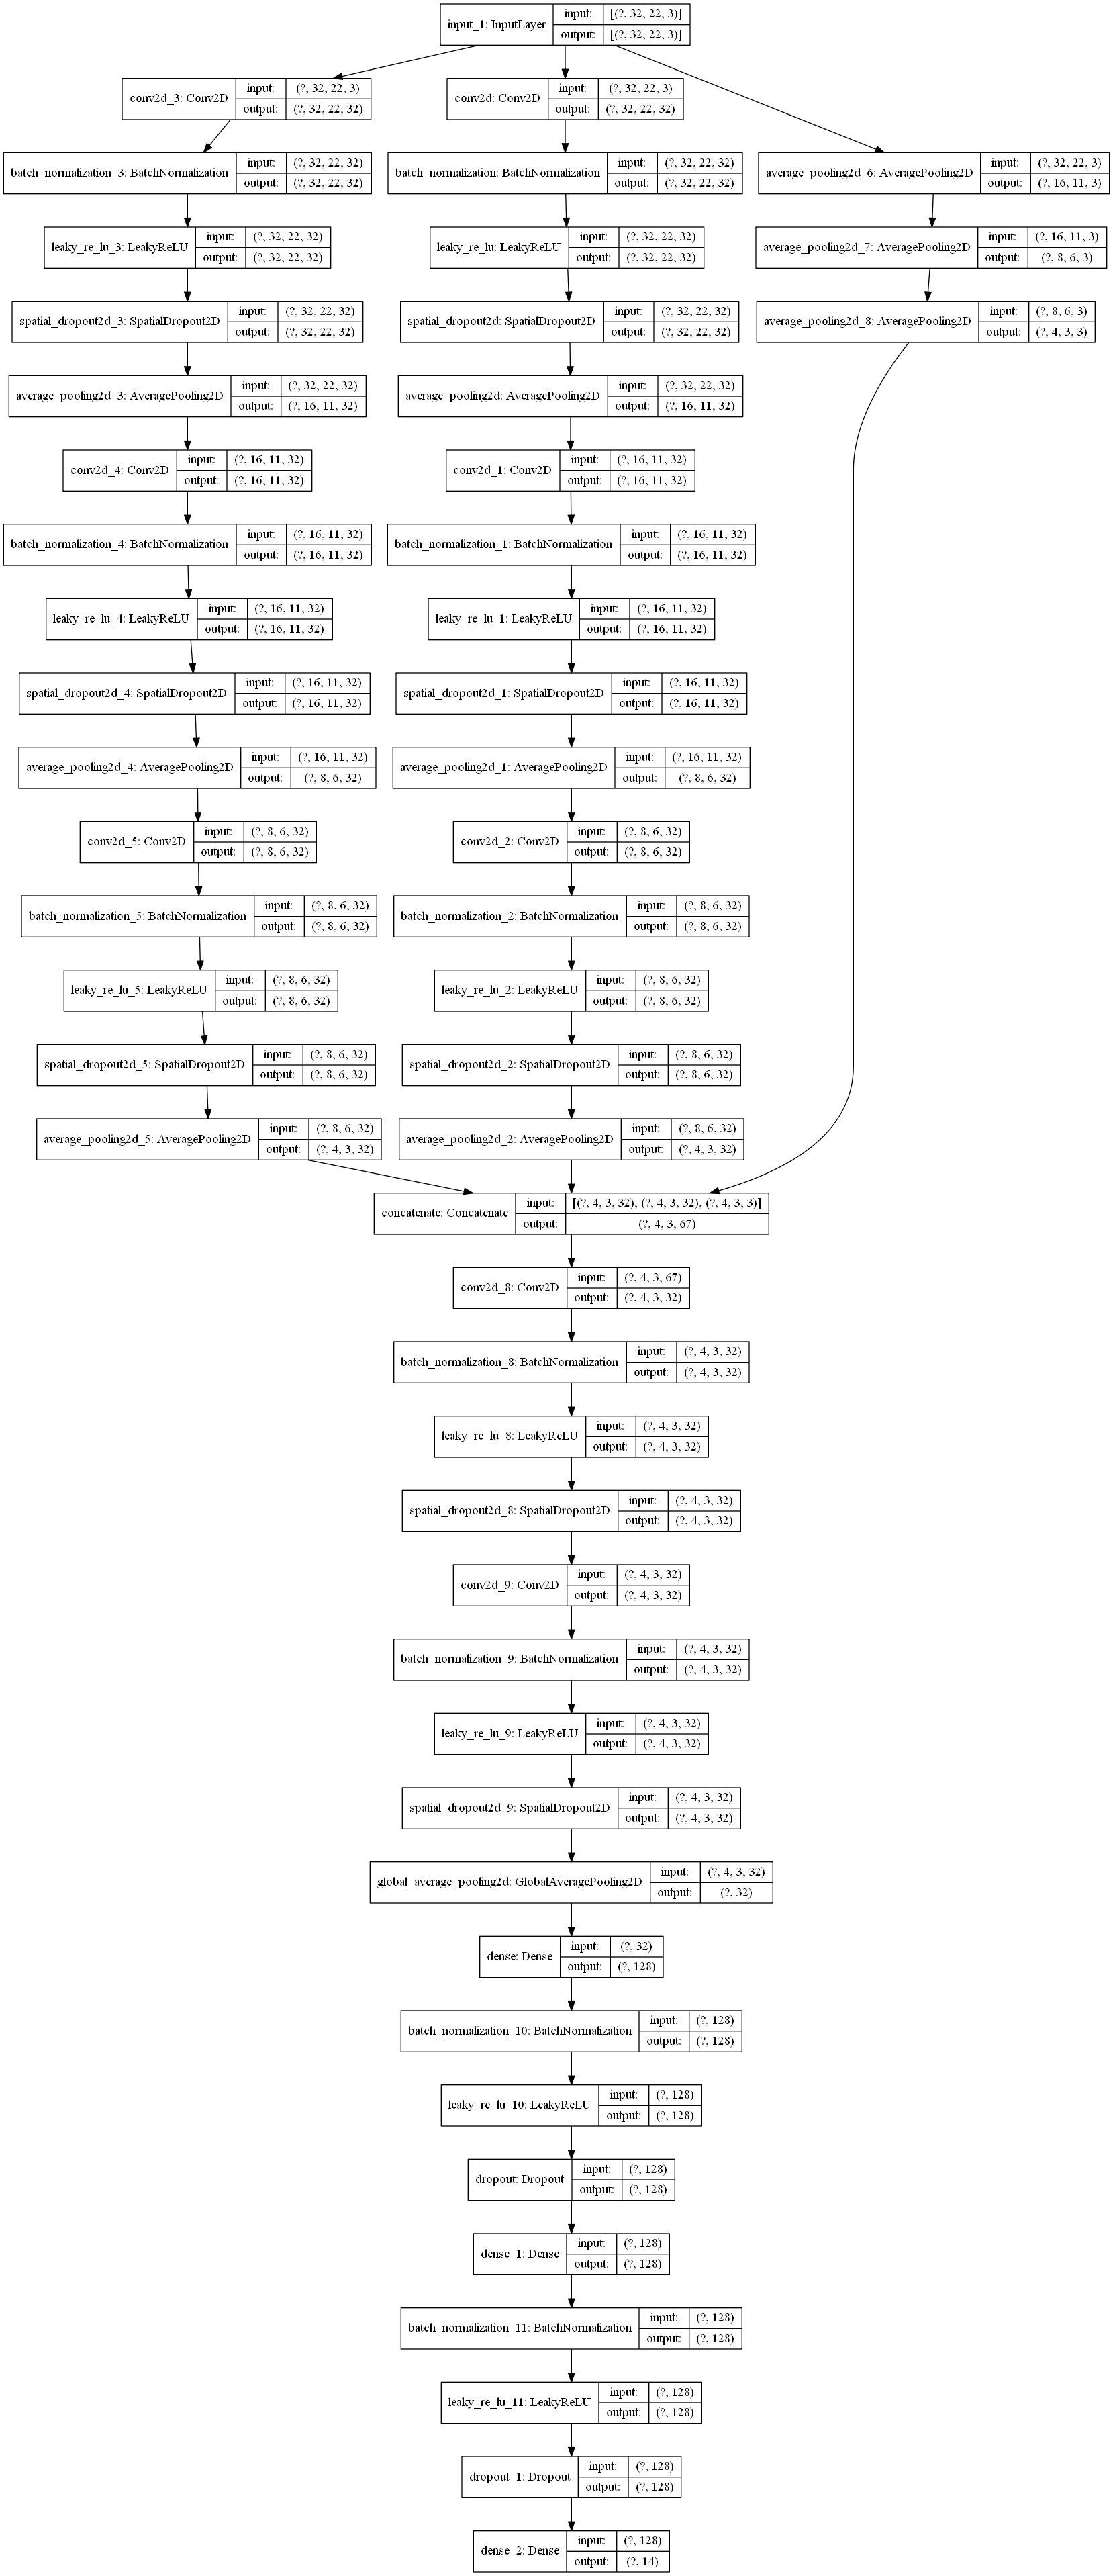

In [10]:
plot_model(model, to_file='model.png', show_shapes=True)

In [11]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [12]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  2%|█▌                                                                             | 40/1960 [00:00<00:09, 196.47it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:10<00:00, 194.94it/s]


In [13]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 840/840 [00:04<00:00, 203.34it/s]


In [14]:
X_1 = np.concatenate((X_1, X_test_1), axis=0)
print(X_1.shape)
Y = np.concatenate((Y,Y_test),axis=0)
print(Y.shape)


model = KerasClassifier(build_fn=create_model, epochs=100, verbose=1)
# define the grid search parameters
batch_size = [8,16,32,64,128,256,512,1024]
param_grid = dict(batch_size = batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=3, cv=3)
grid_result = grid.fit(X_1, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

(2800, 32, 22, 3)
(2800, 14)
Train on 2800 samples
Epoch 1/100
2800/2800 [==============================] - ETA: 1:18 - loss: 3.0545 - acc: 0.031 - ETA: 40s - loss: 2.9306 - acc: 0.062 - ETA: 27s - loss: 2.7816 - acc: 0.09 - ETA: 21s - loss: 2.7112 - acc: 0.10 - ETA: 17s - loss: 2.6417 - acc: 0.13 - ETA: 14s - loss: 2.5601 - acc: 0.15 - ETA: 12s - loss: 2.5059 - acc: 0.16 - ETA: 11s - loss: 2.4394 - acc: 0.18 - ETA: 10s - loss: 2.3796 - acc: 0.20 - ETA: 9s - loss: 2.3408 - acc: 0.2172 - ETA: 8s - loss: 2.2781 - acc: 0.233 - ETA: 7s - loss: 2.2344 - acc: 0.250 - ETA: 7s - loss: 2.1934 - acc: 0.262 - ETA: 6s - loss: 2.1515 - acc: 0.273 - ETA: 6s - loss: 2.1270 - acc: 0.285 - ETA: 5s - loss: 2.0830 - acc: 0.303 - ETA: 5s - loss: 2.0453 - acc: 0.317 - ETA: 5s - loss: 2.0140 - acc: 0.323 - ETA: 4s - loss: 1.9885 - acc: 0.333 - ETA: 4s - loss: 1.9581 - acc: 0.339 - ETA: 4s - loss: 1.9262 - acc: 0.349 - ETA: 4s - loss: 1.8909 - acc: 0.360 - ETA: 3s - loss: 1.8721 - acc: 0.367 - ETA: 3s - loss

2800/2800 [==============================] - ETA: 4s - loss: 0.7730 - acc: 0.765 - ETA: 4s - loss: 0.6299 - acc: 0.796 - ETA: 4s - loss: 0.6027 - acc: 0.807 - ETA: 4s - loss: 0.5760 - acc: 0.816 - ETA: 4s - loss: 0.5429 - acc: 0.834 - ETA: 4s - loss: 0.5381 - acc: 0.833 - ETA: 3s - loss: 0.5488 - acc: 0.830 - ETA: 3s - loss: 0.5298 - acc: 0.834 - ETA: 3s - loss: 0.5273 - acc: 0.835 - ETA: 3s - loss: 0.5079 - acc: 0.842 - ETA: 3s - loss: 0.5002 - acc: 0.836 - ETA: 3s - loss: 0.4878 - acc: 0.843 - ETA: 3s - loss: 0.4914 - acc: 0.841 - ETA: 3s - loss: 0.4962 - acc: 0.835 - ETA: 3s - loss: 0.5065 - acc: 0.834 - ETA: 2s - loss: 0.5003 - acc: 0.835 - ETA: 2s - loss: 0.4987 - acc: 0.839 - ETA: 2s - loss: 0.4857 - acc: 0.844 - ETA: 2s - loss: 0.4819 - acc: 0.846 - ETA: 2s - loss: 0.4766 - acc: 0.847 - ETA: 2s - loss: 0.4798 - acc: 0.846 - ETA: 2s - loss: 0.4770 - acc: 0.848 - ETA: 2s - loss: 0.4861 - acc: 0.845 - ETA: 2s - loss: 0.4796 - acc: 0.848 - ETA: 1s - loss: 0.4700 - acc: 0.851 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.2006 - acc: 0.921 - ETA: 4s - loss: 0.2721 - acc: 0.898 - ETA: 4s - loss: 0.2655 - acc: 0.901 - ETA: 4s - loss: 0.2550 - acc: 0.906 - ETA: 4s - loss: 0.2605 - acc: 0.903 - ETA: 4s - loss: 0.2618 - acc: 0.903 - ETA: 3s - loss: 0.2511 - acc: 0.912 - ETA: 3s - loss: 0.2524 - acc: 0.912 - ETA: 3s - loss: 0.2689 - acc: 0.909 - ETA: 3s - loss: 0.2604 - acc: 0.915 - ETA: 3s - loss: 0.2679 - acc: 0.913 - ETA: 3s - loss: 0.2805 - acc: 0.907 - ETA: 3s - loss: 0.2814 - acc: 0.907 - ETA: 3s - loss: 0.2935 - acc: 0.905 - ETA: 3s - loss: 0.2843 - acc: 0.909 - ETA: 2s - loss: 0.2875 - acc: 0.908 - ETA: 2s - loss: 0.2913 - acc: 0.907 - ETA: 2s - loss: 0.2876 - acc: 0.908 - ETA: 2s - loss: 0.2851 - acc: 0.909 - ETA: 2s - loss: 0.2916 - acc: 0.907 - ETA: 2s - loss: 0.2937 - acc: 0.905 - ETA: 2s - loss: 0.2896 - acc: 0.905 - ETA: 2s - loss: 0.2890 - acc: 0.906 - ETA: 2s - loss: 0.2998 - acc: 0.903 - ETA: 1s - loss: 0.2984 - acc: 0.903 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.2797 - acc: 0.921 - ETA: 4s - loss: 0.2367 - acc: 0.929 - ETA: 4s - loss: 0.2422 - acc: 0.932 - ETA: 4s - loss: 0.2326 - acc: 0.937 - ETA: 4s - loss: 0.2253 - acc: 0.940 - ETA: 3s - loss: 0.2525 - acc: 0.934 - ETA: 3s - loss: 0.2535 - acc: 0.933 - ETA: 3s - loss: 0.2615 - acc: 0.927 - ETA: 3s - loss: 0.2874 - acc: 0.918 - ETA: 3s - loss: 0.2778 - acc: 0.920 - ETA: 3s - loss: 0.2691 - acc: 0.921 - ETA: 3s - loss: 0.2684 - acc: 0.921 - ETA: 3s - loss: 0.2585 - acc: 0.924 - ETA: 3s - loss: 0.2572 - acc: 0.924 - ETA: 2s - loss: 0.2640 - acc: 0.922 - ETA: 2s - loss: 0.2664 - acc: 0.920 - ETA: 2s - loss: 0.2690 - acc: 0.918 - ETA: 2s - loss: 0.2690 - acc: 0.916 - ETA: 2s - loss: 0.2634 - acc: 0.917 - ETA: 2s - loss: 0.2689 - acc: 0.917 - ETA: 2s - loss: 0.2742 - acc: 0.915 - ETA: 2s - loss: 0.2754 - acc: 0.916 - ETA: 2s - loss: 0.2862 - acc: 0.910 - ETA: 2s - loss: 0.2845 - acc: 0.910 - ETA: 1s - loss: 0.2816 - acc: 0.911 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.1574 - acc: 0.937 - ETA: 4s - loss: 0.1455 - acc: 0.945 - ETA: 4s - loss: 0.1576 - acc: 0.937 - ETA: 4s - loss: 0.1622 - acc: 0.937 - ETA: 4s - loss: 0.1790 - acc: 0.934 - ETA: 3s - loss: 0.2340 - acc: 0.927 - ETA: 3s - loss: 0.2461 - acc: 0.921 - ETA: 3s - loss: 0.2347 - acc: 0.923 - ETA: 3s - loss: 0.2184 - acc: 0.928 - ETA: 3s - loss: 0.2140 - acc: 0.929 - ETA: 3s - loss: 0.2184 - acc: 0.930 - ETA: 3s - loss: 0.2200 - acc: 0.932 - ETA: 3s - loss: 0.2205 - acc: 0.933 - ETA: 3s - loss: 0.2210 - acc: 0.934 - ETA: 2s - loss: 0.2255 - acc: 0.931 - ETA: 2s - loss: 0.2208 - acc: 0.932 - ETA: 2s - loss: 0.2185 - acc: 0.934 - ETA: 2s - loss: 0.2119 - acc: 0.937 - ETA: 2s - loss: 0.2070 - acc: 0.939 - ETA: 2s - loss: 0.2050 - acc: 0.939 - ETA: 2s - loss: 0.2033 - acc: 0.941 - ETA: 2s - loss: 0.2005 - acc: 0.942 - ETA: 2s - loss: 0.2028 - acc: 0.942 - ETA: 2s - loss: 0.2032 - acc: 0.940 - ETA: 1s - loss: 0.2070 - acc: 0.938 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.1811 - acc: 0.906 - ETA: 4s - loss: 0.1858 - acc: 0.921 - ETA: 4s - loss: 0.2128 - acc: 0.916 - ETA: 4s - loss: 0.2299 - acc: 0.918 - ETA: 4s - loss: 0.2148 - acc: 0.925 - ETA: 3s - loss: 0.2139 - acc: 0.927 - ETA: 3s - loss: 0.2054 - acc: 0.928 - ETA: 3s - loss: 0.1945 - acc: 0.931 - ETA: 3s - loss: 0.1851 - acc: 0.934 - ETA: 3s - loss: 0.1852 - acc: 0.932 - ETA: 3s - loss: 0.2030 - acc: 0.930 - ETA: 3s - loss: 0.1941 - acc: 0.933 - ETA: 3s - loss: 0.1874 - acc: 0.935 - ETA: 3s - loss: 0.1878 - acc: 0.934 - ETA: 2s - loss: 0.1966 - acc: 0.930 - ETA: 2s - loss: 0.1967 - acc: 0.927 - ETA: 2s - loss: 0.2018 - acc: 0.926 - ETA: 2s - loss: 0.1964 - acc: 0.928 - ETA: 2s - loss: 0.1945 - acc: 0.929 - ETA: 2s - loss: 0.1914 - acc: 0.931 - ETA: 2s - loss: 0.1961 - acc: 0.929 - ETA: 2s - loss: 0.1932 - acc: 0.930 - ETA: 2s - loss: 0.1900 - acc: 0.932 - ETA: 2s - loss: 0.2039 - acc: 0.929 - ETA: 1s - loss: 0.2101 - acc: 0.926 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.1975 - acc: 0.953 - ETA: 4s - loss: 0.1553 - acc: 0.960 - ETA: 4s - loss: 0.1350 - acc: 0.958 - ETA: 4s - loss: 0.1410 - acc: 0.957 - ETA: 4s - loss: 0.1609 - acc: 0.946 - ETA: 4s - loss: 0.1579 - acc: 0.945 - ETA: 3s - loss: 0.1731 - acc: 0.939 - ETA: 3s - loss: 0.1829 - acc: 0.941 - ETA: 3s - loss: 0.1928 - acc: 0.937 - ETA: 3s - loss: 0.1820 - acc: 0.942 - ETA: 3s - loss: 0.1754 - acc: 0.944 - ETA: 3s - loss: 0.1698 - acc: 0.945 - ETA: 3s - loss: 0.1682 - acc: 0.944 - ETA: 3s - loss: 0.1712 - acc: 0.945 - ETA: 3s - loss: 0.1717 - acc: 0.945 - ETA: 3s - loss: 0.1717 - acc: 0.945 - ETA: 2s - loss: 0.1762 - acc: 0.943 - ETA: 2s - loss: 0.1727 - acc: 0.942 - ETA: 2s - loss: 0.1674 - acc: 0.944 - ETA: 2s - loss: 0.1649 - acc: 0.944 - ETA: 2s - loss: 0.1620 - acc: 0.944 - ETA: 2s - loss: 0.1599 - acc: 0.946 - ETA: 2s - loss: 0.1566 - acc: 0.948 - ETA: 2s - loss: 0.1560 - acc: 0.948 - ETA: 2s - loss: 0.1522 - acc: 0.950 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.0528 - acc: 0.984 - ETA: 4s - loss: 0.1169 - acc: 0.960 - ETA: 4s - loss: 0.1063 - acc: 0.963 - ETA: 4s - loss: 0.1191 - acc: 0.957 - ETA: 3s - loss: 0.1208 - acc: 0.953 - ETA: 3s - loss: 0.1396 - acc: 0.953 - ETA: 3s - loss: 0.1343 - acc: 0.950 - ETA: 3s - loss: 0.1289 - acc: 0.953 - ETA: 3s - loss: 0.1274 - acc: 0.953 - ETA: 3s - loss: 0.1200 - acc: 0.954 - ETA: 3s - loss: 0.1198 - acc: 0.954 - ETA: 3s - loss: 0.1146 - acc: 0.957 - ETA: 3s - loss: 0.1217 - acc: 0.954 - ETA: 3s - loss: 0.1204 - acc: 0.955 - ETA: 2s - loss: 0.1217 - acc: 0.955 - ETA: 2s - loss: 0.1253 - acc: 0.955 - ETA: 2s - loss: 0.1380 - acc: 0.953 - ETA: 2s - loss: 0.1350 - acc: 0.954 - ETA: 2s - loss: 0.1380 - acc: 0.952 - ETA: 2s - loss: 0.1380 - acc: 0.951 - ETA: 2s - loss: 0.1363 - acc: 0.951 - ETA: 2s - loss: 0.1338 - acc: 0.952 - ETA: 2s - loss: 0.1331 - acc: 0.953 - ETA: 2s - loss: 0.1315 - acc: 0.953 - ETA: 1s - loss: 0.1376 - acc: 0.951 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.1259 - acc: 0.937 - ETA: 4s - loss: 0.1556 - acc: 0.929 - ETA: 4s - loss: 0.1135 - acc: 0.953 - ETA: 4s - loss: 0.1042 - acc: 0.957 - ETA: 4s - loss: 0.0949 - acc: 0.962 - ETA: 3s - loss: 0.0948 - acc: 0.963 - ETA: 3s - loss: 0.0936 - acc: 0.966 - ETA: 3s - loss: 0.0893 - acc: 0.968 - ETA: 3s - loss: 0.1022 - acc: 0.965 - ETA: 3s - loss: 0.1010 - acc: 0.967 - ETA: 3s - loss: 0.0960 - acc: 0.970 - ETA: 3s - loss: 0.0961 - acc: 0.968 - ETA: 3s - loss: 0.1009 - acc: 0.965 - ETA: 3s - loss: 0.0974 - acc: 0.966 - ETA: 2s - loss: 0.1083 - acc: 0.963 - ETA: 2s - loss: 0.1071 - acc: 0.964 - ETA: 2s - loss: 0.1101 - acc: 0.962 - ETA: 2s - loss: 0.1079 - acc: 0.963 - ETA: 2s - loss: 0.1118 - acc: 0.961 - ETA: 2s - loss: 0.1157 - acc: 0.960 - ETA: 2s - loss: 0.1169 - acc: 0.959 - ETA: 2s - loss: 0.1140 - acc: 0.960 - ETA: 2s - loss: 0.1145 - acc: 0.959 - ETA: 2s - loss: 0.1148 - acc: 0.959 - ETA: 1s - loss: 0.1146 - acc: 0.960 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.0472 - acc: 1.000 - ETA: 4s - loss: 0.0873 - acc: 0.976 - ETA: 4s - loss: 0.0861 - acc: 0.968 - ETA: 4s - loss: 0.1018 - acc: 0.964 - ETA: 4s - loss: 0.0989 - acc: 0.965 - ETA: 3s - loss: 0.1104 - acc: 0.963 - ETA: 3s - loss: 0.1250 - acc: 0.957 - ETA: 3s - loss: 0.1199 - acc: 0.957 - ETA: 3s - loss: 0.1346 - acc: 0.953 - ETA: 3s - loss: 0.1375 - acc: 0.954 - ETA: 3s - loss: 0.1282 - acc: 0.958 - ETA: 3s - loss: 0.1210 - acc: 0.960 - ETA: 3s - loss: 0.1229 - acc: 0.960 - ETA: 3s - loss: 0.1177 - acc: 0.962 - ETA: 2s - loss: 0.1137 - acc: 0.963 - ETA: 2s - loss: 0.1123 - acc: 0.962 - ETA: 2s - loss: 0.1091 - acc: 0.964 - ETA: 2s - loss: 0.1234 - acc: 0.961 - ETA: 2s - loss: 0.1243 - acc: 0.959 - ETA: 2s - loss: 0.1223 - acc: 0.959 - ETA: 2s - loss: 0.1225 - acc: 0.960 - ETA: 2s - loss: 0.1225 - acc: 0.960 - ETA: 2s - loss: 0.1224 - acc: 0.960 - ETA: 2s - loss: 0.1243 - acc: 0.959 - ETA: 1s - loss: 0.1255 - acc: 0.958 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.1107 - acc: 0.937 - ETA: 4s - loss: 0.1255 - acc: 0.953 - ETA: 4s - loss: 0.1109 - acc: 0.958 - ETA: 4s - loss: 0.1079 - acc: 0.957 - ETA: 3s - loss: 0.1047 - acc: 0.962 - ETA: 3s - loss: 0.0966 - acc: 0.966 - ETA: 3s - loss: 0.1294 - acc: 0.957 - ETA: 3s - loss: 0.1284 - acc: 0.955 - ETA: 3s - loss: 0.1351 - acc: 0.954 - ETA: 3s - loss: 0.1336 - acc: 0.953 - ETA: 3s - loss: 0.1310 - acc: 0.953 - ETA: 3s - loss: 0.1284 - acc: 0.954 - ETA: 3s - loss: 0.1311 - acc: 0.954 - ETA: 3s - loss: 0.1259 - acc: 0.955 - ETA: 3s - loss: 0.1368 - acc: 0.951 - ETA: 2s - loss: 0.1331 - acc: 0.952 - ETA: 2s - loss: 0.1345 - acc: 0.952 - ETA: 2s - loss: 0.1347 - acc: 0.954 - ETA: 2s - loss: 0.1301 - acc: 0.955 - ETA: 2s - loss: 0.1271 - acc: 0.957 - ETA: 2s - loss: 0.1260 - acc: 0.957 - ETA: 2s - loss: 0.1233 - acc: 0.958 - ETA: 2s - loss: 0.1213 - acc: 0.959 - ETA: 2s - loss: 0.1196 - acc: 0.960 - ETA: 1s - loss: 0.1179 - acc: 0.961 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.1249 - acc: 0.984 - ETA: 4s - loss: 0.1585 - acc: 0.945 - ETA: 4s - loss: 0.1362 - acc: 0.947 - ETA: 4s - loss: 0.1064 - acc: 0.960 - ETA: 3s - loss: 0.0982 - acc: 0.965 - ETA: 3s - loss: 0.1037 - acc: 0.966 - ETA: 3s - loss: 0.0971 - acc: 0.968 - ETA: 3s - loss: 0.0917 - acc: 0.972 - ETA: 3s - loss: 0.1020 - acc: 0.972 - ETA: 3s - loss: 0.1057 - acc: 0.970 - ETA: 3s - loss: 0.1094 - acc: 0.970 - ETA: 3s - loss: 0.1260 - acc: 0.962 - ETA: 3s - loss: 0.1210 - acc: 0.962 - ETA: 3s - loss: 0.1191 - acc: 0.962 - ETA: 2s - loss: 0.1245 - acc: 0.959 - ETA: 2s - loss: 0.1236 - acc: 0.960 - ETA: 2s - loss: 0.1190 - acc: 0.962 - ETA: 2s - loss: 0.1152 - acc: 0.963 - ETA: 2s - loss: 0.1119 - acc: 0.963 - ETA: 2s - loss: 0.1086 - acc: 0.964 - ETA: 2s - loss: 0.1094 - acc: 0.965 - ETA: 2s - loss: 0.1059 - acc: 0.965 - ETA: 2s - loss: 0.1032 - acc: 0.967 - ETA: 2s - loss: 0.1028 - acc: 0.968 - ETA: 1s - loss: 0.1057 - acc: 0.967 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.0581 - acc: 0.984 - ETA: 4s - loss: 0.0621 - acc: 0.984 - ETA: 4s - loss: 0.0586 - acc: 0.989 - ETA: 4s - loss: 0.0581 - acc: 0.984 - ETA: 4s - loss: 0.0543 - acc: 0.987 - ETA: 4s - loss: 0.0490 - acc: 0.989 - ETA: 3s - loss: 0.0492 - acc: 0.988 - ETA: 3s - loss: 0.0532 - acc: 0.986 - ETA: 3s - loss: 0.0493 - acc: 0.987 - ETA: 3s - loss: 0.0540 - acc: 0.985 - ETA: 3s - loss: 0.0520 - acc: 0.987 - ETA: 3s - loss: 0.0554 - acc: 0.987 - ETA: 3s - loss: 0.0541 - acc: 0.986 - ETA: 3s - loss: 0.0562 - acc: 0.985 - ETA: 3s - loss: 0.0606 - acc: 0.984 - ETA: 3s - loss: 0.0613 - acc: 0.984 - ETA: 2s - loss: 0.0663 - acc: 0.983 - ETA: 2s - loss: 0.0696 - acc: 0.980 - ETA: 2s - loss: 0.0695 - acc: 0.981 - ETA: 2s - loss: 0.0697 - acc: 0.981 - ETA: 2s - loss: 0.0712 - acc: 0.980 - ETA: 2s - loss: 0.0707 - acc: 0.980 - ETA: 2s - loss: 0.0699 - acc: 0.980 - ETA: 2s - loss: 0.0715 - acc: 0.979 - ETA: 2s - loss: 0.0701 - acc: 0.980 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.0515 - acc: 0.984 - ETA: 4s - loss: 0.0509 - acc: 0.984 - ETA: 4s - loss: 0.0397 - acc: 0.989 - ETA: 4s - loss: 0.0423 - acc: 0.988 - ETA: 4s - loss: 0.0442 - acc: 0.987 - ETA: 3s - loss: 0.0637 - acc: 0.976 - ETA: 3s - loss: 0.0683 - acc: 0.977 - ETA: 3s - loss: 0.0641 - acc: 0.980 - ETA: 3s - loss: 0.0620 - acc: 0.980 - ETA: 3s - loss: 0.0836 - acc: 0.975 - ETA: 3s - loss: 0.0812 - acc: 0.975 - ETA: 3s - loss: 0.0892 - acc: 0.970 - ETA: 3s - loss: 0.0877 - acc: 0.971 - ETA: 3s - loss: 0.0831 - acc: 0.973 - ETA: 3s - loss: 0.0853 - acc: 0.969 - ETA: 2s - loss: 0.0842 - acc: 0.970 - ETA: 2s - loss: 0.0808 - acc: 0.971 - ETA: 2s - loss: 0.0789 - acc: 0.972 - ETA: 2s - loss: 0.0763 - acc: 0.973 - ETA: 2s - loss: 0.0768 - acc: 0.972 - ETA: 2s - loss: 0.0798 - acc: 0.971 - ETA: 2s - loss: 0.0784 - acc: 0.971 - ETA: 2s - loss: 0.0768 - acc: 0.972 - ETA: 2s - loss: 0.0748 - acc: 0.973 - ETA: 1s - loss: 0.0741 - acc: 0.973 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.0345 - acc: 0.984 - ETA: 4s - loss: 0.0529 - acc: 0.984 - ETA: 4s - loss: 0.0587 - acc: 0.984 - ETA: 4s - loss: 0.0780 - acc: 0.980 - ETA: 4s - loss: 0.0748 - acc: 0.978 - ETA: 4s - loss: 0.0648 - acc: 0.981 - ETA: 3s - loss: 0.0694 - acc: 0.979 - ETA: 3s - loss: 0.0632 - acc: 0.982 - ETA: 3s - loss: 0.0578 - acc: 0.984 - ETA: 3s - loss: 0.0601 - acc: 0.984 - ETA: 3s - loss: 0.0647 - acc: 0.983 - ETA: 3s - loss: 0.0639 - acc: 0.981 - ETA: 3s - loss: 0.0700 - acc: 0.979 - ETA: 3s - loss: 0.0690 - acc: 0.978 - ETA: 3s - loss: 0.0676 - acc: 0.980 - ETA: 2s - loss: 0.0669 - acc: 0.980 - ETA: 2s - loss: 0.0695 - acc: 0.978 - ETA: 2s - loss: 0.0668 - acc: 0.980 - ETA: 2s - loss: 0.0657 - acc: 0.980 - ETA: 2s - loss: 0.0700 - acc: 0.979 - ETA: 2s - loss: 0.0731 - acc: 0.979 - ETA: 2s - loss: 0.0754 - acc: 0.978 - ETA: 2s - loss: 0.0777 - acc: 0.978 - ETA: 2s - loss: 0.0762 - acc: 0.978 - ETA: 1s - loss: 0.0762 - acc: 0.978 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.0504 - acc: 0.984 - ETA: 4s - loss: 0.0626 - acc: 0.976 - ETA: 4s - loss: 0.0648 - acc: 0.974 - ETA: 4s - loss: 0.0823 - acc: 0.972 - ETA: 4s - loss: 0.0718 - acc: 0.975 - ETA: 3s - loss: 0.0670 - acc: 0.974 - ETA: 3s - loss: 0.0642 - acc: 0.975 - ETA: 3s - loss: 0.0608 - acc: 0.976 - ETA: 3s - loss: 0.0562 - acc: 0.979 - ETA: 3s - loss: 0.0661 - acc: 0.975 - ETA: 3s - loss: 0.0669 - acc: 0.975 - ETA: 3s - loss: 0.0639 - acc: 0.976 - ETA: 3s - loss: 0.0748 - acc: 0.971 - ETA: 3s - loss: 0.0796 - acc: 0.968 - ETA: 3s - loss: 0.0869 - acc: 0.964 - ETA: 2s - loss: 0.0915 - acc: 0.962 - ETA: 2s - loss: 0.0881 - acc: 0.965 - ETA: 2s - loss: 0.0865 - acc: 0.966 - ETA: 2s - loss: 0.0855 - acc: 0.967 - ETA: 2s - loss: 0.0862 - acc: 0.967 - ETA: 2s - loss: 0.0838 - acc: 0.968 - ETA: 2s - loss: 0.0827 - acc: 0.969 - ETA: 2s - loss: 0.0814 - acc: 0.970 - ETA: 2s - loss: 0.0795 - acc: 0.971 - ETA: 1s - loss: 0.0769 - acc: 0.972 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.0363 - acc: 0.984 - ETA: 4s - loss: 0.0627 - acc: 0.976 - ETA: 4s - loss: 0.0914 - acc: 0.974 - ETA: 4s - loss: 0.0743 - acc: 0.980 - ETA: 4s - loss: 0.0642 - acc: 0.984 - ETA: 3s - loss: 0.0554 - acc: 0.987 - ETA: 3s - loss: 0.0524 - acc: 0.986 - ETA: 3s - loss: 0.0553 - acc: 0.984 - ETA: 3s - loss: 0.0581 - acc: 0.982 - ETA: 3s - loss: 0.0545 - acc: 0.984 - ETA: 3s - loss: 0.0519 - acc: 0.985 - ETA: 3s - loss: 0.0517 - acc: 0.985 - ETA: 3s - loss: 0.0598 - acc: 0.982 - ETA: 3s - loss: 0.0570 - acc: 0.983 - ETA: 3s - loss: 0.0543 - acc: 0.984 - ETA: 2s - loss: 0.0516 - acc: 0.985 - ETA: 2s - loss: 0.0571 - acc: 0.983 - ETA: 2s - loss: 0.0588 - acc: 0.982 - ETA: 2s - loss: 0.0573 - acc: 0.983 - ETA: 2s - loss: 0.0559 - acc: 0.983 - ETA: 2s - loss: 0.0575 - acc: 0.982 - ETA: 2s - loss: 0.0599 - acc: 0.982 - ETA: 2s - loss: 0.0587 - acc: 0.983 - ETA: 2s - loss: 0.0647 - acc: 0.981 - ETA: 2s - loss: 0.0656 - acc: 0.980 - ETA: 

2800/2800 [==============================] - ETA: 5s - loss: 0.0470 - acc: 0.984 - ETA: 4s - loss: 0.0377 - acc: 0.992 - ETA: 4s - loss: 0.0515 - acc: 0.984 - ETA: 4s - loss: 0.0685 - acc: 0.980 - ETA: 4s - loss: 0.0816 - acc: 0.975 - ETA: 4s - loss: 0.0888 - acc: 0.974 - ETA: 4s - loss: 0.0779 - acc: 0.977 - ETA: 3s - loss: 0.0687 - acc: 0.980 - ETA: 3s - loss: 0.0636 - acc: 0.980 - ETA: 3s - loss: 0.0639 - acc: 0.979 - ETA: 3s - loss: 0.0612 - acc: 0.980 - ETA: 3s - loss: 0.0611 - acc: 0.980 - ETA: 3s - loss: 0.0637 - acc: 0.979 - ETA: 3s - loss: 0.0676 - acc: 0.977 - ETA: 3s - loss: 0.0654 - acc: 0.978 - ETA: 3s - loss: 0.0762 - acc: 0.977 - ETA: 2s - loss: 0.0729 - acc: 0.978 - ETA: 2s - loss: 0.0704 - acc: 0.980 - ETA: 2s - loss: 0.0683 - acc: 0.980 - ETA: 2s - loss: 0.0747 - acc: 0.978 - ETA: 2s - loss: 0.0737 - acc: 0.977 - ETA: 2s - loss: 0.0747 - acc: 0.978 - ETA: 2s - loss: 0.0720 - acc: 0.978 - ETA: 2s - loss: 0.0702 - acc: 0.979 - ETA: 2s - loss: 0.0730 - acc: 0.977 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.0940 - acc: 0.953 - ETA: 4s - loss: 0.1243 - acc: 0.953 - ETA: 4s - loss: 0.1156 - acc: 0.947 - ETA: 4s - loss: 0.0936 - acc: 0.960 - ETA: 4s - loss: 0.0852 - acc: 0.968 - ETA: 4s - loss: 0.0771 - acc: 0.974 - ETA: 3s - loss: 0.0746 - acc: 0.973 - ETA: 3s - loss: 0.0688 - acc: 0.976 - ETA: 3s - loss: 0.0734 - acc: 0.977 - ETA: 3s - loss: 0.0710 - acc: 0.978 - ETA: 3s - loss: 0.0656 - acc: 0.980 - ETA: 3s - loss: 0.0762 - acc: 0.977 - ETA: 3s - loss: 0.0766 - acc: 0.976 - ETA: 3s - loss: 0.0794 - acc: 0.976 - ETA: 3s - loss: 0.0780 - acc: 0.977 - ETA: 2s - loss: 0.0765 - acc: 0.977 - ETA: 2s - loss: 0.0808 - acc: 0.976 - ETA: 2s - loss: 0.0821 - acc: 0.975 - ETA: 2s - loss: 0.0790 - acc: 0.977 - ETA: 2s - loss: 0.0782 - acc: 0.976 - ETA: 2s - loss: 0.0756 - acc: 0.977 - ETA: 2s - loss: 0.0748 - acc: 0.978 - ETA: 2s - loss: 0.0762 - acc: 0.977 - ETA: 2s - loss: 0.0803 - acc: 0.975 - ETA: 1s - loss: 0.0780 - acc: 0.976 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.1943 - acc: 0.953 - ETA: 4s - loss: 0.1457 - acc: 0.968 - ETA: 4s - loss: 0.1058 - acc: 0.979 - ETA: 4s - loss: 0.0840 - acc: 0.984 - ETA: 4s - loss: 0.0702 - acc: 0.987 - ETA: 3s - loss: 0.0675 - acc: 0.984 - ETA: 3s - loss: 0.0731 - acc: 0.982 - ETA: 3s - loss: 0.0668 - acc: 0.984 - ETA: 3s - loss: 0.0682 - acc: 0.984 - ETA: 3s - loss: 0.0652 - acc: 0.985 - ETA: 3s - loss: 0.0614 - acc: 0.987 - ETA: 3s - loss: 0.0576 - acc: 0.988 - ETA: 3s - loss: 0.0538 - acc: 0.989 - ETA: 3s - loss: 0.0588 - acc: 0.987 - ETA: 3s - loss: 0.0560 - acc: 0.988 - ETA: 2s - loss: 0.0574 - acc: 0.988 - ETA: 2s - loss: 0.0568 - acc: 0.987 - ETA: 2s - loss: 0.0553 - acc: 0.987 - ETA: 2s - loss: 0.0581 - acc: 0.986 - ETA: 2s - loss: 0.0628 - acc: 0.983 - ETA: 2s - loss: 0.0609 - acc: 0.984 - ETA: 2s - loss: 0.0608 - acc: 0.984 - ETA: 2s - loss: 0.0587 - acc: 0.985 - ETA: 2s - loss: 0.0647 - acc: 0.982 - ETA: 1s - loss: 0.0625 - acc: 0.983 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.0196 - acc: 1.000 - ETA: 4s - loss: 0.0531 - acc: 0.976 - ETA: 4s - loss: 0.0492 - acc: 0.974 - ETA: 4s - loss: 0.0664 - acc: 0.968 - ETA: 4s - loss: 0.0584 - acc: 0.971 - ETA: 4s - loss: 0.0620 - acc: 0.968 - ETA: 4s - loss: 0.0557 - acc: 0.973 - ETA: 3s - loss: 0.0610 - acc: 0.972 - ETA: 3s - loss: 0.0557 - acc: 0.975 - ETA: 3s - loss: 0.0532 - acc: 0.976 - ETA: 3s - loss: 0.0512 - acc: 0.977 - ETA: 3s - loss: 0.0517 - acc: 0.977 - ETA: 3s - loss: 0.0507 - acc: 0.978 - ETA: 3s - loss: 0.0479 - acc: 0.979 - ETA: 3s - loss: 0.0470 - acc: 0.980 - ETA: 3s - loss: 0.0492 - acc: 0.979 - ETA: 2s - loss: 0.0529 - acc: 0.978 - ETA: 2s - loss: 0.0522 - acc: 0.979 - ETA: 2s - loss: 0.0508 - acc: 0.980 - ETA: 2s - loss: 0.0497 - acc: 0.980 - ETA: 2s - loss: 0.0483 - acc: 0.981 - ETA: 2s - loss: 0.0504 - acc: 0.980 - ETA: 2s - loss: 0.0486 - acc: 0.981 - ETA: 2s - loss: 0.0483 - acc: 0.981 - ETA: 2s - loss: 0.0507 - acc: 0.980 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.0038 - acc: 1.000 - ETA: 4s - loss: 0.0114 - acc: 1.000 - ETA: 4s - loss: 0.0139 - acc: 1.000 - ETA: 4s - loss: 0.0394 - acc: 0.988 - ETA: 4s - loss: 0.0408 - acc: 0.984 - ETA: 4s - loss: 0.0368 - acc: 0.987 - ETA: 3s - loss: 0.0534 - acc: 0.977 - ETA: 3s - loss: 0.0561 - acc: 0.976 - ETA: 3s - loss: 0.0514 - acc: 0.979 - ETA: 3s - loss: 0.0489 - acc: 0.981 - ETA: 3s - loss: 0.0502 - acc: 0.980 - ETA: 3s - loss: 0.0491 - acc: 0.980 - ETA: 3s - loss: 0.0505 - acc: 0.980 - ETA: 3s - loss: 0.0581 - acc: 0.981 - ETA: 3s - loss: 0.0547 - acc: 0.982 - ETA: 3s - loss: 0.0587 - acc: 0.980 - ETA: 2s - loss: 0.0573 - acc: 0.981 - ETA: 2s - loss: 0.0559 - acc: 0.981 - ETA: 2s - loss: 0.0538 - acc: 0.982 - ETA: 2s - loss: 0.0574 - acc: 0.981 - ETA: 2s - loss: 0.0550 - acc: 0.982 - ETA: 2s - loss: 0.0556 - acc: 0.982 - ETA: 2s - loss: 0.0557 - acc: 0.982 - ETA: 2s - loss: 0.0554 - acc: 0.981 - ETA: 2s - loss: 0.0567 - acc: 0.981 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.0162 - acc: 1.000 - ETA: 4s - loss: 0.0430 - acc: 0.992 - ETA: 4s - loss: 0.0347 - acc: 0.994 - ETA: 4s - loss: 0.0441 - acc: 0.988 - ETA: 4s - loss: 0.0374 - acc: 0.990 - ETA: 3s - loss: 0.0331 - acc: 0.992 - ETA: 3s - loss: 0.0296 - acc: 0.993 - ETA: 3s - loss: 0.0286 - acc: 0.994 - ETA: 3s - loss: 0.0363 - acc: 0.989 - ETA: 3s - loss: 0.0351 - acc: 0.990 - ETA: 3s - loss: 0.0331 - acc: 0.991 - ETA: 3s - loss: 0.0322 - acc: 0.990 - ETA: 3s - loss: 0.0328 - acc: 0.990 - ETA: 3s - loss: 0.0367 - acc: 0.988 - ETA: 3s - loss: 0.0360 - acc: 0.989 - ETA: 2s - loss: 0.0380 - acc: 0.988 - ETA: 2s - loss: 0.0412 - acc: 0.987 - ETA: 2s - loss: 0.0394 - acc: 0.987 - ETA: 2s - loss: 0.0378 - acc: 0.988 - ETA: 2s - loss: 0.0408 - acc: 0.988 - ETA: 2s - loss: 0.0420 - acc: 0.988 - ETA: 2s - loss: 0.0407 - acc: 0.988 - ETA: 2s - loss: 0.0399 - acc: 0.989 - ETA: 2s - loss: 0.0423 - acc: 0.988 - ETA: 1s - loss: 0.0433 - acc: 0.988 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.1311 - acc: 0.968 - ETA: 4s - loss: 0.0665 - acc: 0.984 - ETA: 4s - loss: 0.0556 - acc: 0.979 - ETA: 4s - loss: 0.0438 - acc: 0.984 - ETA: 4s - loss: 0.0605 - acc: 0.981 - ETA: 3s - loss: 0.0649 - acc: 0.981 - ETA: 3s - loss: 0.0658 - acc: 0.982 - ETA: 3s - loss: 0.0613 - acc: 0.982 - ETA: 3s - loss: 0.0593 - acc: 0.984 - ETA: 3s - loss: 0.0598 - acc: 0.981 - ETA: 3s - loss: 0.0599 - acc: 0.981 - ETA: 3s - loss: 0.0567 - acc: 0.983 - ETA: 3s - loss: 0.0562 - acc: 0.983 - ETA: 3s - loss: 0.0584 - acc: 0.983 - ETA: 3s - loss: 0.0572 - acc: 0.983 - ETA: 2s - loss: 0.0552 - acc: 0.984 - ETA: 2s - loss: 0.0589 - acc: 0.982 - ETA: 2s - loss: 0.0588 - acc: 0.982 - ETA: 2s - loss: 0.0580 - acc: 0.981 - ETA: 2s - loss: 0.0587 - acc: 0.981 - ETA: 2s - loss: 0.0574 - acc: 0.982 - ETA: 2s - loss: 0.0564 - acc: 0.982 - ETA: 2s - loss: 0.0568 - acc: 0.981 - ETA: 2s - loss: 0.0559 - acc: 0.981 - ETA: 1s - loss: 0.0549 - acc: 0.982 - ETA: 

2800/2800 [==============================] - ETA: 4s - loss: 0.0584 - acc: 0.968 - ETA: 4s - loss: 0.0679 - acc: 0.968 - ETA: 4s - loss: 0.0551 - acc: 0.979 - ETA: 4s - loss: 0.0484 - acc: 0.984 - ETA: 4s - loss: 0.0454 - acc: 0.984 - ETA: 3s - loss: 0.0525 - acc: 0.979 - ETA: 3s - loss: 0.0539 - acc: 0.979 - ETA: 3s - loss: 0.0500 - acc: 0.982 - ETA: 3s - loss: 0.0464 - acc: 0.984 - ETA: 3s - loss: 0.0497 - acc: 0.984 - ETA: 3s - loss: 0.0510 - acc: 0.983 - ETA: 3s - loss: 0.0551 - acc: 0.983 - ETA: 3s - loss: 0.0573 - acc: 0.982 - ETA: 3s - loss: 0.0554 - acc: 0.982 - ETA: 3s - loss: 0.0541 - acc: 0.982 - ETA: 2s - loss: 0.0509 - acc: 0.983 - ETA: 2s - loss: 0.0489 - acc: 0.984 - ETA: 2s - loss: 0.0485 - acc: 0.984 - ETA: 2s - loss: 0.0468 - acc: 0.985 - ETA: 2s - loss: 0.0451 - acc: 0.985 - ETA: 2s - loss: 0.0455 - acc: 0.985 - ETA: 2s - loss: 0.0443 - acc: 0.986 - ETA: 2s - loss: 0.0441 - acc: 0.986 - ETA: 2s - loss: 0.0490 - acc: 0.985 - ETA: 1s - loss: 0.0487 - acc: 0.985 - ETA: 

In [15]:
print(X_1.shape)

(2800, 32, 22, 3)


In [16]:
print(Y.shape)

(2800, 14)
